In [ ]:
# before we get started! lets turn on the GPU for our google colab session:
# In google colab, Select > Edit... > Notebook Settings... > Hardware Accelerator > GPU

# we will use the GPU later on when we start training our linknet model
# see more information on how to ensure your GPU is working at:
# https://colab.research.google.com/notebooks/gpu.ipynb

In [ ]:
# we will be training a linknet deep learning image segmentation model which has been pretrained on imagenet
# this pretrained model is accessed though https://github.com/qubvel/segmentation_models

# this notebook is following partially on a tutorial https://www.youtube.com/watch?v=NUvmHYTQxrs
# were the code can be accessed https://github.com/bnsreenu/python_for_microscopists/blob/master/211_multiclass_Unet_vs_linknet.py
# the above tutorial even has data provided if you want to recreate the results https://drive.google.com/file/d/1HWtBaSa-LTyAMgf2uaz1T9o1sTWDBajU/view
# great stuff! 


In [ ]:
# honestly this tutorial is a great deal better than those provided by tensorflow https://www.tensorflow.org/tutorials/images/segmentation
# some some training data is available https://keras.io/api/datasets/ 
# BUT - we will be creating our own data from google map tile API

In [ ]:
#lets get our own data!
!pip install git+https://github.com/NSCC-COGS/Aestheta.git -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 225kB 18.1MB/s 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from aestheta import core

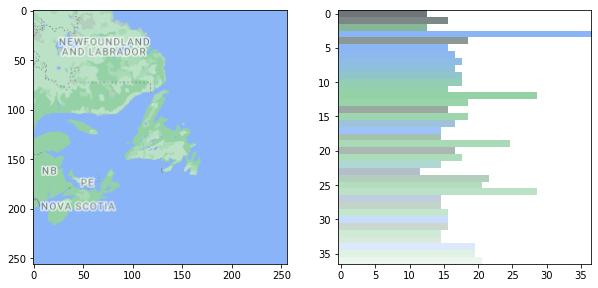

In [ ]:
coord =  [44.6488, -63.5752,4] # halifax

arr = core.getTile(coord, source='google_map')
hist = core.histogram_from_image(arr)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1); plt.imshow(arr)
plt.subplot(1,2,2); plt.imshow(hist)

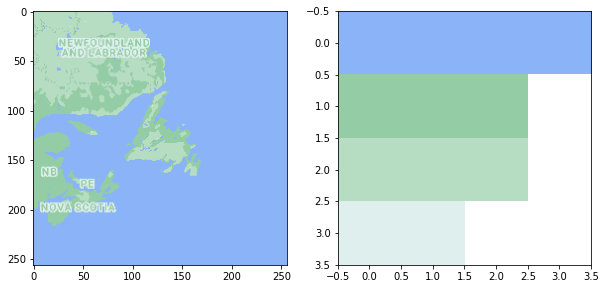

In [ ]:
arr_k, lut = core.kmeans(arr, k=4, return_lut = True)
hist_k = core.histogram_from_image(arr_k)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1); plt.imshow(arr_k)
plt.subplot(1,2,2); plt.imshow(hist_k)

In [ ]:
lut

array([[148, 204, 165, 255],
       [223, 239, 237, 255],
       [182, 221, 193, 255],
       [138, 180, 247, 255]], dtype=uint8)

In [ ]:
import cv2

def QuantizeToGivenPalette(im, palette):
  # https://stackoverflow.com/questions/57177649/how-can-i-quickly-change-pixels-in-a-image-from-a-color-dictionary
    """Quantize image to a given palette.

    The input image is expected to be a Numpy array.
    The palette is expected to be a list of R,G,B values."""

    # Calculate the distance to each palette entry from each pixel
    distance = np.linalg.norm(im[:,:,None] - palette[None,None,:].astype(int), axis=3)

    # Now choose whichever one of the palette colours is nearest for each pixel
    palettised = np.argmin(distance, axis=2).astype(np.uint8)

    return palettised

def applyPalette(im, palette):
    im_out = palette[im]
    return im_out

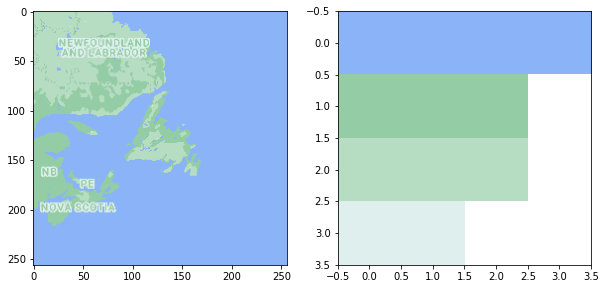

In [ ]:
arr_k2 = QuantizeToGivenPalette(arr,lut)
arr_k2 = applyPalette(arr_k2,lut)
hist_k2 = core.histogram_from_image(arr_k2)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1); plt.imshow(arr_k2)
plt.subplot(1,2,2); plt.imshow(hist_k2)

In [ ]:
print(repr(lut))

array([[148, 204, 165, 255],
       [223, 239, 237, 255],
       [182, 221, 193, 255],
       [138, 180, 247, 255]], dtype=uint8)


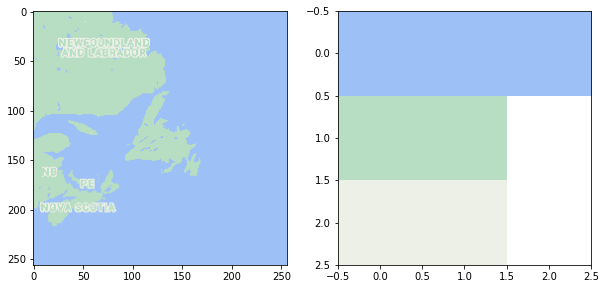

In [ ]:
custom_lut = np.array([[237, 240, 231, 255],
       [183, 222, 194, 255],
       [241, 198,  87, 255],
       [157, 193, 246, 255]])

arr_k2_custom = QuantizeToGivenPalette(arr,custom_lut)
arr_k2_custom  = applyPalette(arr_k2_custom ,custom_lut)
hist_k2_custom  = core.histogram_from_image(arr_k2_custom)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1); plt.imshow(arr_k2_custom)
plt.subplot(1,2,2); plt.imshow(hist_k2_custom)

In [ ]:
def makeTrainingData():
  zoom = 4
  size = 2**zoom
  earth = np.zeros((size,size,3), dtype=int)
  print(size)

  samples = []
  segments = []

  sample_source = 'google_sat'
  segment_source = 'google_map'

  print('getting training data..')

  for x in range(0,size):
    for y in range(0,size):
      # print(x,y, zoom)
      print('.', end="")
      try:
        sample = core.getTile(xyz=[x,y,zoom],source=sample_source)
        samples.append(sample)
        segment = core.getTile(xyz=[x,y,zoom],source=segment_source)
        segments.append(segment)
      except Exception as e: 
        print(e) # in some cases, no tile exists - such as in the ocean or at the poles
        # pass
  print('done')
  print(f'%i taining images taken from the earth!' % len(samples))
  return samples, segments

In [ ]:
samples, segments = makeTrainingData()

16
getting training data..
................................................................................................................................................................................................................................................................done
256 taining images taken from the earth!


In [ ]:
samples_arr = np.array(samples)
segments_arr = np.array(segments)

In [ ]:
samples_arr.shape, segments_arr.shape

((256, 256, 256, 3), (256, 256, 256, 4))

In [ ]:
segments_arr_feats = segments_arr.reshape(-1, segments_arr.shape[-1])
segments_arr_feats.shape

(16777216, 4)

In [ ]:
def QuantizeToGivenPalette_features(feats, palette):
  # https://stackoverflow.com/questions/57177649/how-can-i-quickly-change-pixels-in-a-image-from-a-color-dictionary
    """Quantize image to a given palette.

    The input image is expected to be a Numpy array.
    The palette is expected to be a list of R,G,B values."""

    # Calculate the distance to each palette entry from each pixel
    distance = np.linalg.norm(feats[:,None] - palette[None,None,:].astype(int), axis=3)

    # Now choose whichever one of the palette colours is nearest for each pixel
    palettised = np.argmin(distance, axis=2).astype(np.uint8)

    return palettised

In [ ]:
segments_arr_code = QuantizeToGivenPalette_features(segments_arr_feats,lut)

In [ ]:
segments_arr_code = segments_arr_code.reshape(256,256,256,1)

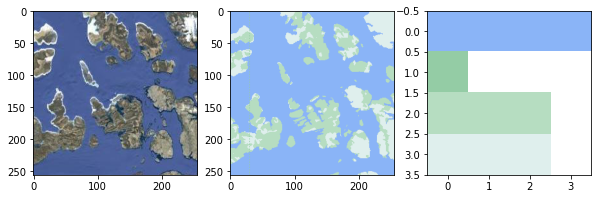

In [ ]:
def showTrainingData(test_index = 50):
  imTest = segments_arr_code[test_index,...,0]
  imTest_color = applyPalette(imTest ,lut)
  histTest = core.histogram_from_image(imTest_color)

  plt.figure(figsize=(10,10))
  plt.subplot(1,3,1); plt.imshow(samples_arr[test_index])
  plt.subplot(1,3,2); plt.imshow(imTest_color)
  plt.subplot(1,3,3); plt.imshow(histTest)

showTrainingData()

In [ ]:
def tileSplit(arr):
  #expects arrays like (256, 256, 256, 3) where [0] is number of images
  # an alternative way we can do this https://stackoverflow.com/questions/64902241/how-to-split-a-picture-in-numpy-array-format
  count,height,width,bands = arr.shape
  double_count = int(count*2)
  quad_count = int(count*4)
  half_height = int(height/2)
  half_width = int(width/2)
  arr_split = arr.reshape(double_count,half_height,width,bands, order='C')
  arr_split = np.transpose(arr_split, axes=(0,2,1,3))
  arr_split = arr_split.reshape(quad_count,half_width,half_height,bands, order='C')
  arr_split = np.transpose(arr_split, axes=(0,2,1,3))
  return arr_split

In [ ]:
def tileSplit_reverse(arr):
  #expects arrays like (1024, 128, 128, 3) where [0] is number of images
  count,height,width,bands = arr.shape
  double_count = int(count/2)
  quad_count = int(count/4)
  half_height = int(height*2)
  half_width = int(width*2)
  arr_split = np.transpose(arr, axes=(0,2,1,3))
  arr_split = arr_split.reshape(double_count,half_height,width,bands, order='C')
  arr_split = np.transpose(arr_split, axes=(0,2,1,3))
  arr_split = arr_split.reshape(quad_count,half_width,half_height,bands, order='C')
  # arr_split = np.transpose(arr_split, axes=(0,2,1,3))
  return arr_split

In [ ]:
def tileSplit_two(arr, reverse=False):
  #expects arrays like (256, 256, 256, 3) where [0] is number of images
  count,height,width,bands = arr.shape
  if reverse:
    a,b = [1/2,2]
  else:
    a,b = [2,1/2]
  double_count = int(count*a)
  quad_count = int(double_count*a)
  half_height = int(height*b)
  half_width = int(width*b)
  arr_split = arr.reshape(double_count,half_height,width,bands, order='C')
  arr_split = np.transpose(arr_split, axes=(0,2,1,3))
  arr_split = arr_split.reshape(quad_count,half_width,half_height,bands, order='C')
  arr_split = np.transpose(arr_split, axes=(0,2,1,3))
  return arr_split

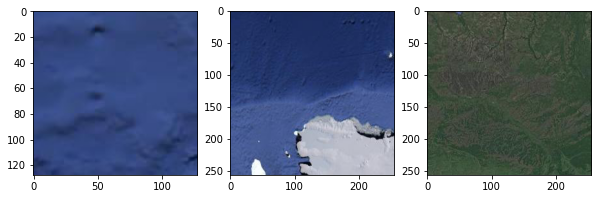

In [ ]:
def testTileSplit():
  samples_arr_128_TEST = tileSplit(samples_arr)
  # samples_arr_128_TEST_UNDO = tileSplit_two(samples_arr_128_TEST, reverse=True)
  samples_arr_128_TEST_UNDO = tileSplit_reverse(samples_arr_128_TEST)
  plt.figure(figsize=(10,10))
  plt.subplot(1,3,1); plt.imshow(samples_arr_128_TEST[0])
  plt.subplot(1,3,2); plt.imshow(samples_arr_128_TEST_UNDO[60])
  plt.subplot(1,3,3); plt.imshow(samples_arr_128_TEST_UNDO[180])

testTileSplit()

In [ ]:
#so lets split up our image data into smaller 128x128 tiles

samples_arr_128 = tileSplit(samples_arr)
segments_arr_128 = tileSplit(segments_arr_code)

samples_arr_128.shape, segments_arr_128.shape

((1024, 128, 128, 3), (1024, 128, 128, 1))

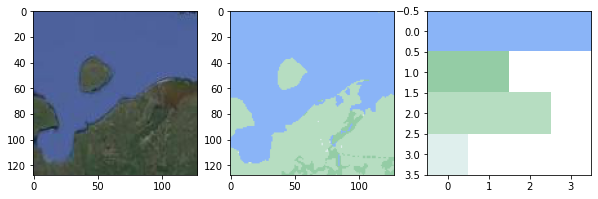

In [ ]:
def showTrainingData_split(test_index = 654):
  imTest = segments_arr_128[test_index,...,0]

  imTest_color = applyPalette(imTest ,lut)
  histTest = core.histogram_from_image(imTest_color)

  plt.figure(figsize=(10,10))
  plt.subplot(1,3,1); plt.imshow(samples_arr_128[test_index])
  plt.subplot(1,3,2); plt.imshow(imTest_color)
  plt.subplot(1,3,3); plt.imshow(histTest)

showTrainingData_split()

#Follow the guide

In [ ]:
# code from https://github.com/bnsreenu/python_for_microscopists/blob/master/211_multiclass_Unet_vs_linknet.py

In [ ]:
#fit ours data into was guide did
train_masks = segments_arr_128[...,0]
train_images = samples_arr_128

print(train_images.shape,train_masks.shape)

(1024, 128, 128, 3) (1024, 128, 128)


In [ ]:
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3])

In [ ]:
!pip install segmentation_models

     |████████████████████████████████| 51kB 7.1MB/s 


In [ ]:
import tensorflow as tf
import keras 
# %env SM_FRAMEWORK=tf.keras #https://github.com/qubvel/segmentation_models/issues/374

import os
os.environ["SM_FRAMEWORK"] = "tf.keras" #https://github.com/qubvel/segmentation_models/issues/268


import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

import pandas as pd
from datetime import datetime 

from keras.utils import normalize
#from keras.metrics import MeanIoU

Segmentation Models: using `tf.keras` framework.


In [ ]:
n_classes = 4

#train_images = np.expand_dims(train_images, axis=3)
#train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.5, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 

from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))



test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

Class values in the dataset are ...  [0 1 2 3]


In [ ]:
BACKBONE1 = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# preprocess input
X_train1 = preprocess_input1(X_train)
X_test1 = preprocess_input1(X_test)

In [ ]:
######################################################
#Reused parameters in all models

n_classes=4
activation='softmax'

LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]


########################################################################

In [ ]:
###Model 2
#Using the same backbone as unet

# define model (Change to unet or Linknet based on the need )
model2 = sm.Linknet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model2.compile(optim, total_loss, metrics=metrics)

print(model2.summary())

start2 = datetime.now() 

# with tf.device('/cpu:0'):
with tf.device('/device:GPU:0'):
  history2=model2.fit(X_train1, 
            y_train_cat,
            batch_size=8, 
            epochs=10,
            verbose=1,
            validation_data=(X_test1, y_test_cat))

stop2 = datetime.now()

#Execution time of the model 
execution_time_linknet = stop2-start2
print("Linknet execution time is: ", execution_time_linknet)

model2.save('linknet_res34_backbone_10epochs.hdf5')

85524480/85521592 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d[0][0]             
___________________________

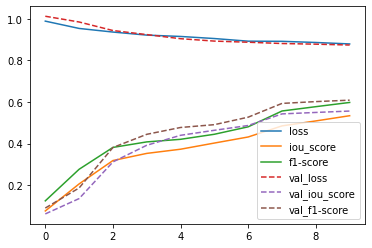

In [ ]:
def plot_model(history = history2):
  for i in history.history.keys():
    if 'val' in i:
      style = '--'
    else:
      style ='-'
    plt.plot(history.history[i], label=i, linestyle=style) #https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html
  plt.legend()

plot_model()

[0 1 2 3]


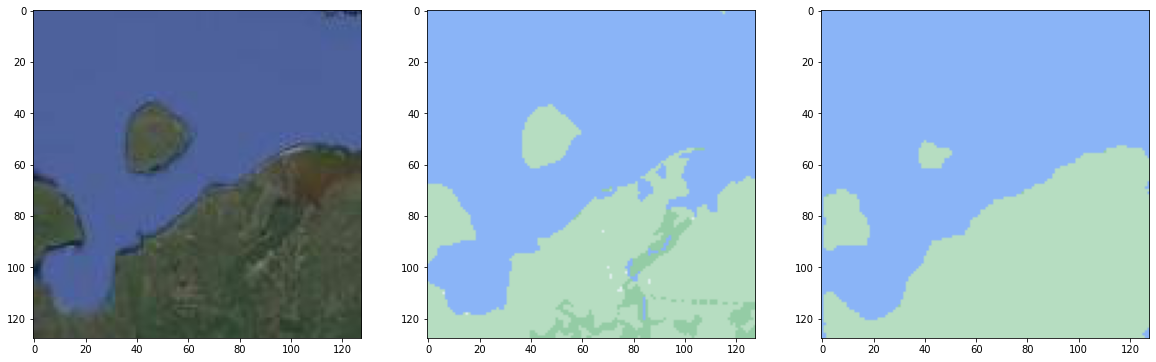

In [ ]:
def testModel(test_index = 654):
  imTest = segments_arr_128[test_index,...,0]

  print(np.unique(imTest))

  imTest_color = applyPalette(imTest ,lut)
  histTest = core.histogram_from_image(imTest_color)

  imgTest_sat = samples_arr_128[test_index]
  imgTest_model = model2.predict(np.expand_dims(imgTest_sat, axis=0))
  imgTest_model = imgTest_model[0]
  imgTest_model=imgTest_model.argmax(axis=-1)
  imTest_model_color = applyPalette(imgTest_model ,lut)

  plt.figure(figsize=(20,10))
  plt.subplot(1,3,1); plt.imshow(imgTest_sat)
  plt.subplot(1,3,2); plt.imshow(imTest_color)
  plt.subplot(1,3,3); plt.imshow(imTest_model_color)

testModel()

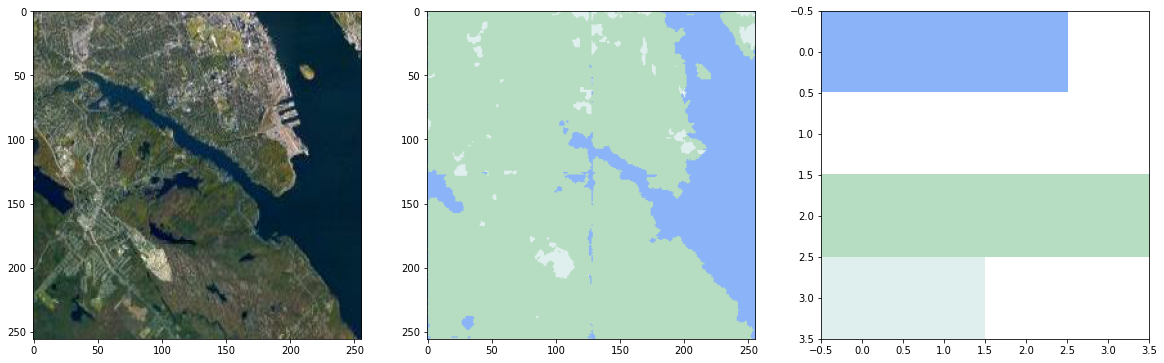

In [ ]:
def testModel_external(coord =  [44.6488, -63.5752,12]):# halifax

  tile = core.getTile(coord,'google_sat')
  # tile_map = core.getTile(coord,'google_sat')

  tile0 = np.expand_dims(tile, axis=0)
  tile0 = tileSplit(tile0)
  arr = model2.predict(tile0)

  arr = tileSplit_reverse(arr)

  img = arr[0]
  img=img.argmax(axis=-1)

  img_color = applyPalette(img ,lut)
  # img_color = applyPalette(img ,custom_lut)
  hist_color = core.histogram_from_image(img_color)

  plt.figure(figsize=(20,10))
  plt.subplot(1,3,1); plt.imshow(tile)
  plt.subplot(1,3,2); plt.imshow(img_color)
  plt.subplot(1,3,3); plt.imshow(hist_color)

testModel_external()

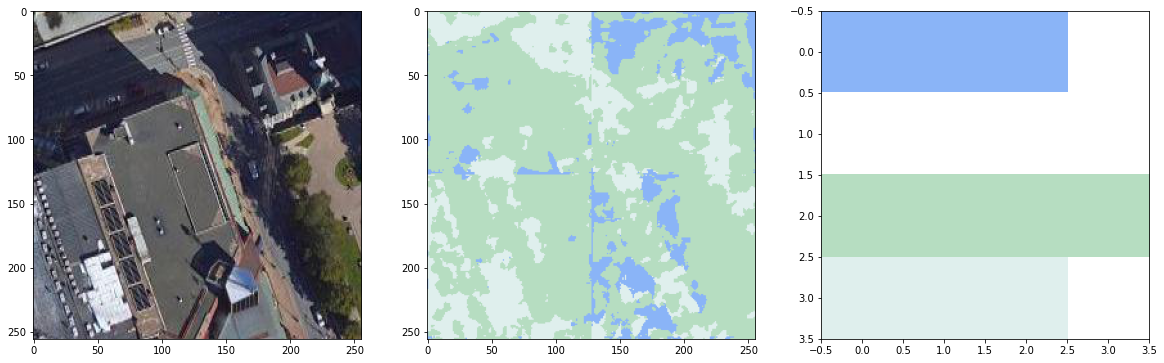

In [ ]:
testModel_external([44.6488, -63.5752,18])

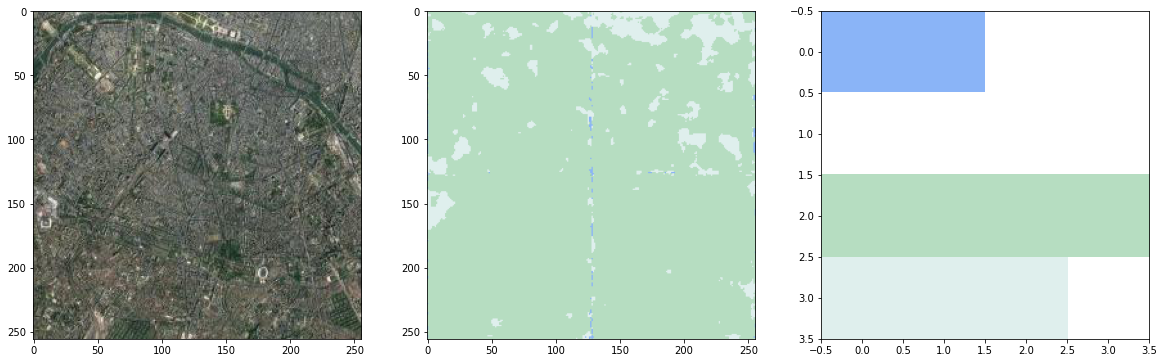

In [ ]:
testModel_external([48.8566,2.3522,12])

In [ ]:
with tf.device('/device:GPU:0'):
  history3=model2.fit(X_train1, 
            y_train_cat,
            batch_size=8, 
            epochs=10,
            verbose=1,
            validation_data=(X_test1, y_test_cat))

Epoch 1/10
58/58 [==============================] - 4s 61ms/step - loss: 0.8749 - iou_score: 0.5344 - f1-score: 0.5991 - val_loss: 0.8708 - val_iou_score: 0.5621 - val_f1-score: 0.6123
Epoch 2/10
58/58 [==============================] - 3s 58ms/step - loss: 0.8690 - iou_score: 0.5548 - f1-score: 0.6162 - val_loss: 0.8690 - val_iou_score: 0.5675 - val_f1-score: 0.6173
Epoch 3/10
58/58 [==============================] - 3s 57ms/step - loss: 0.8667 - iou_score: 0.5609 - f1-score: 0.6233 - val_loss: 0.8670 - val_iou_score: 0.5741 - val_f1-score: 0.6246
Epoch 4/10
58/58 [==============================] - 3s 57ms/step - loss: 0.8662 - iou_score: 0.5546 - f1-score: 0.6158 - val_loss: 0.8698 - val_iou_score: 0.5608 - val_f1-score: 0.6099
Epoch 5/10
58/58 [==============================] - 3s 58ms/step - loss: 0.8668 - iou_score: 0.5580 - f1-score: 0.6184 - val_loss: 0.8636 - val_iou_score: 0.5779 - val_f1-score: 0.6291
Epoch 6/10
58/58 [==============================] - 3s 58ms/step - loss: 0.

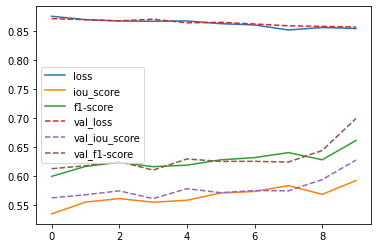

In [ ]:
plot_model(history3)

[0 1 2 3]


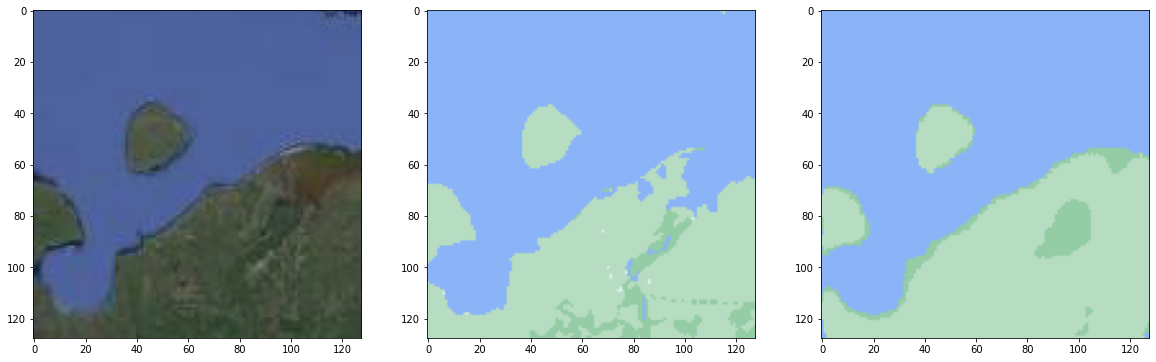

In [ ]:
testModel()

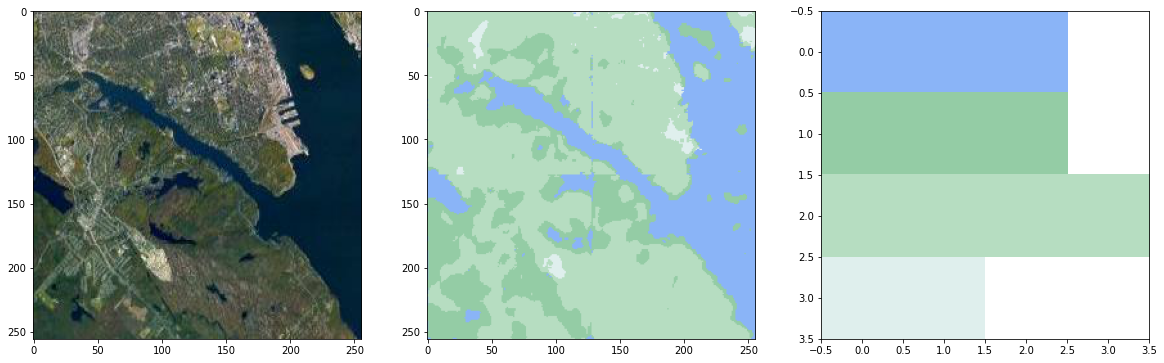

In [ ]:
testModel_external()

In [ ]:
with tf.device('/device:GPU:0'):
  history4=model2.fit(X_train1, 
            y_train_cat,
            batch_size=8, 
            epochs=100,
            verbose=1,
            validation_data=(X_test1, y_test_cat))

Epoch 1/100
58/58 [==============================] - 4s 62ms/step - loss: 0.8547 - iou_score: 0.6043 - f1-score: 0.6821 - val_loss: 0.8581 - val_iou_score: 0.6235 - val_f1-score: 0.6956
Epoch 2/100
58/58 [==============================] - 3s 60ms/step - loss: 0.8403 - iou_score: 0.6573 - f1-score: 0.7361 - val_loss: 0.8533 - val_iou_score: 0.6284 - val_f1-score: 0.7018
Epoch 3/100
58/58 [==============================] - 3s 60ms/step - loss: 0.8481 - iou_score: 0.6386 - f1-score: 0.7205 - val_loss: 0.8529 - val_iou_score: 0.6432 - val_f1-score: 0.7141
Epoch 4/100
58/58 [==============================] - 3s 60ms/step - loss: 0.8394 - iou_score: 0.6692 - f1-score: 0.7483 - val_loss: 0.8514 - val_iou_score: 0.6169 - val_f1-score: 0.6853
Epoch 5/100
58/58 [==============================] - 4s 61ms/step - loss: 0.8450 - iou_score: 0.6379 - f1-score: 0.7216 - val_loss: 0.8514 - val_iou_score: 0.6332 - val_f1-score: 0.7036
Epoch 6/100
58/58 [==============================] - 3s 60ms/step - lo

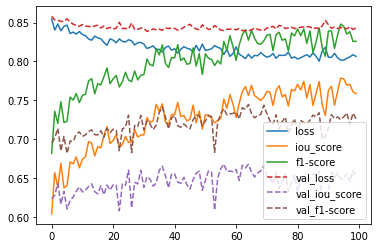

In [ ]:
plot_model(history4)

[0 1 2 3]


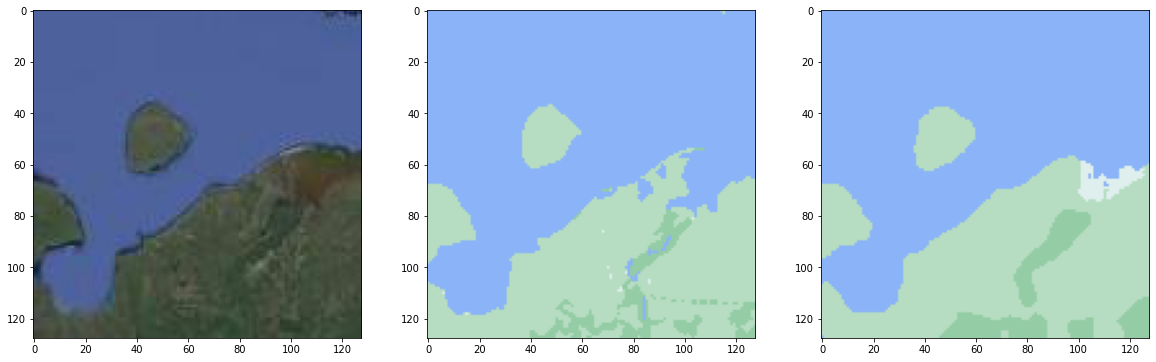

In [ ]:
testModel()

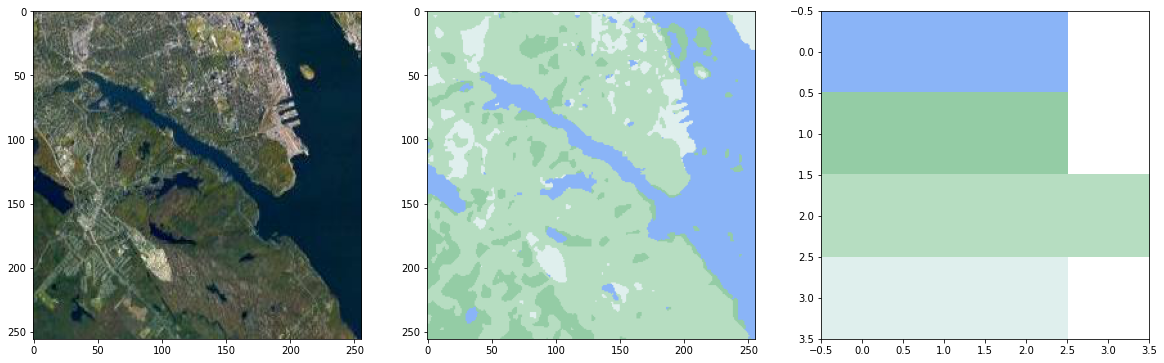

In [ ]:
testModel_external()

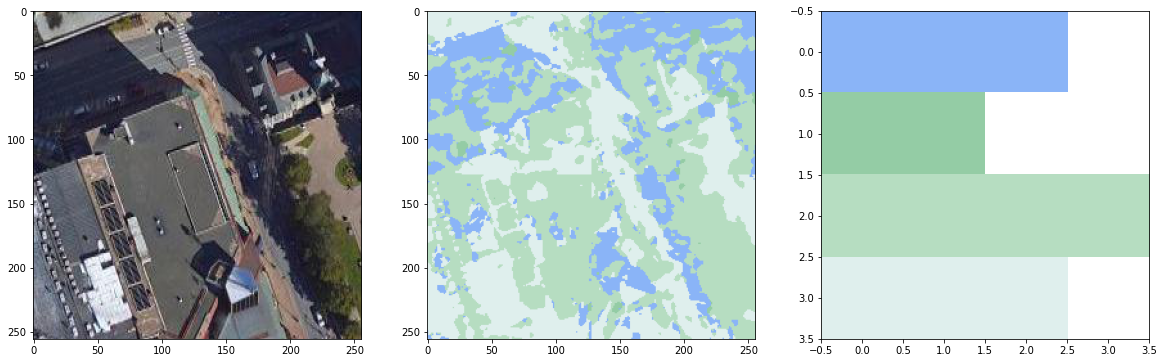

In [ ]:
testModel_external([44.6488, -63.5752,18]) # halifax zoom

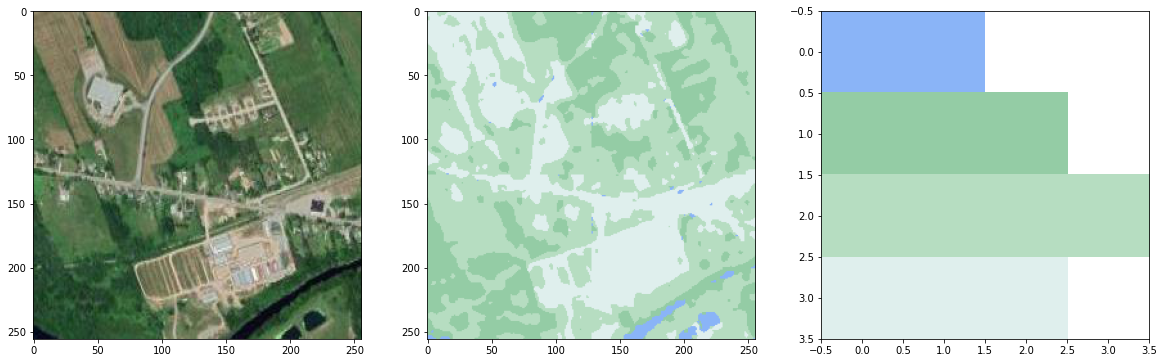

In [ ]:
testModel_external([44.885168,-65.1662588, 15]) #cogs

In [ ]:
model2.save('linknet_res34_backbone_120epochs.hdf5')

In [ ]:
# 'good' models get an iou of maybe 90%
# https://www.researchgate.net/publication/335785978_Performance_Analysis_of_Semantic_Segmentation_Algorithms_for_Finely_Annotated_New_UAV_Aerial_Video_Dataset_ManipalUAVid
# https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

In [ ]:
# SO! our model is starting to overfit!
# lets try MORE data and BETTER data (across more scales!)
# also! lets find better segment data! Ours has labels and generally limited. 

# NOTE <--- look over there in google colab. We can download our model from google coalb and back it up locally
# its suprisingly big! 250 bm! lets make it smaller!